## General

### Installs

In [25]:
%pip install keras
%pip install tensorflow
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports

In [10]:
import os
import keras
import random
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf

from os import path
from keras import layers
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, RandomBrightness, RandomRotation, RandomZoom, RandomContrast
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

## Question 1 A

### Load the data

In [11]:
all_labels = ['NORMAL', 'PNEUMONIA']
# TODO: change it
base_dir = "/Users/neriya.shulman/content/chest_xray"
img_size = 250

In [12]:

def load_data(base_dir, img_size, all_labels):
    dataset = []
    labels = []
    file_names = []
    for dir_ in os.scandir(base_dir):
        if not dir_.is_dir():
            continue
        label = all_labels.index(dir_.name)
        for file in os.scandir(dir_.path):
            if file.name == '.DS_Store':
                continue
            img = load_img(file.path, target_size=(img_size, img_size), color_mode='grayscale')
            arr_img = img_to_array(img)
            dataset.append(arr_img)
            labels.append(label) # change label to 0 or 1
            file_names.append(file.name)
    dataset = np.array(dataset, dtype='float32')
    labels = np.expand_dims(labels, -1)
    file_names = np.expand_dims(file_names, -1)
    return dataset, labels, file_names

In [13]:
test_set, test_labels, _ = load_data(path.join(base_dir, "test"), img_size, all_labels)
test_set /= 255 # normalization

### Load the model

In [14]:
model = load_model('model_q1_a.keras')

2024-04-15 20:48:53.465585: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-15 20:48:53.465604: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-15 20:48:53.465609: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-15 20:48:53.465626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 20:48:53.465637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Show metrics

In [15]:
batch_size = 64
score = model.evaluate(test_set, test_labels, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])

print('Test F1 score:', 2 * (score[2] * score[3]) / (score[2] + score[3]))


2024-04-15 20:48:55.582906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9160 - loss: 0.2421 - precision: 0.9770 - recall: 0.9199
Test loss: 0.35937631130218506
Test accuracy: 0.9006410241127014
Test recall: 0.9153845906257629
Test precision: 0.924870491027832
Test F1 score: 0.9201030925023953


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


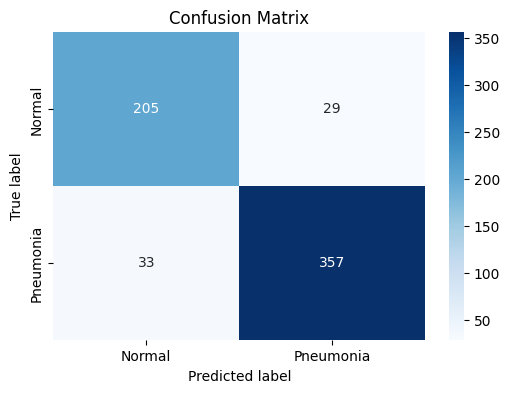

In [16]:

result = model.predict(test_set)
pred_test_labels = np.where(result > 0.5, 1, 0)
conf_matrix = confusion_matrix(test_labels.squeeze(), pred_test_labels.squeeze())

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Question 1 B

### Load the data

In [40]:
all_labels = ['NORMAL', 'virus', 'bacteria']
base_dir = "/Users/neriya.shulman/content/chest_xray"

train_path = path.join(base_dir, "train/")
val_path = path.join(base_dir, "val/")
test_path = path.join(base_dir, "test/")

img_size = 150
print("Image size: ", img_size, "x", img_size)

Image size:  150 x 150


In [41]:
def get_label(dir_name, file_name, file_labels=[]):
    for label in file_labels:
        if label in file_name:
            return label
    return dir_name

def load_data_from_path(base_dir, img_size, file_labels=[]):
    dataset = []
    labels = []
    dir_names = os.path.basename(base_dir)
    for file in os.scandir(base_dir):
        if file.name == '.DS_Store':
            continue
        if file.is_dir():
            dir_images, dir_labels = load_data_from_path(file.path, img_size, file_labels)
            dataset.extend(dir_images)
            labels.extend(dir_labels)
        else:
            img = img_to_array(load_img(file.path, target_size=(img_size, img_size), color_mode='grayscale'))
            dataset.append(img)
            labels.append(get_label(dir_names, file.name, file_labels))
    dataset = np.array(dataset, dtype='float32')
    labels = np.array(labels)
    return dataset, labels

def load_data(path, img_size, all_labels, file_labels=[]):
    dataset, labels = load_data_from_path(path, img_size, file_labels)
    labels = np.array([all_labels.index(label) for label in labels]) # one-hot encoding
    labels = to_categorical(labels, len(all_labels))
    return dataset, labels

In [42]:
test_set, test_labels = load_data(test_path, img_size, all_labels, file_labels=['bacteria', 'virus'])

### Load the model

In [54]:
model = load_model('model_q1_b.keras')

Show the metrics of the model

In [44]:
score = model.evaluate(test_set, test_labels, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])
print('Test F1 score:', 2 * (score[2] * score[3]) / (score[2] + score[3]))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3617 - loss: 73.7078 - precision: 0.3617 - recall: 0.3617
Test loss: 92.17710876464844
Test accuracy: 0.40224358439445496
Test recall: 0.40224358439445496
Test precision: 0.40224358439445496
Test F1 score: 0.40224358439445496


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


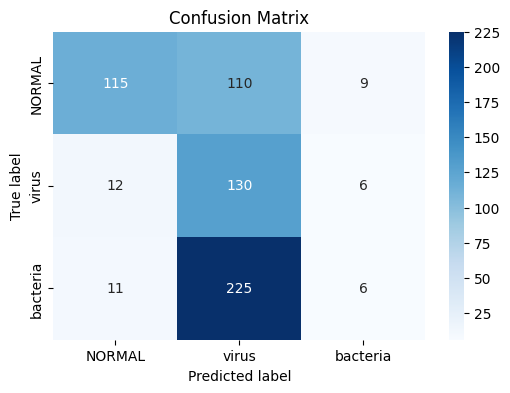

In [49]:

result = model.predict(test_set)
pred_test_labels = np.argmax(result, axis=1)
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), pred_test_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Question 2

## Question 3

### Load data

In [70]:
# TODO: delete it
np.random.seed(100)
random.seed(100)
tf.random.set_seed(100)

image_size = 150
# TODO: change it
base_dir = "/Users/neriya.shulman/content/chest_xray"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [71]:
def load_images(dir_path, image_size):
    images = []
    files = os.listdir(dir_path)
    for filename in files:
        if filename == '.DS_Store':
            continue
        img_path = os.path.join(dir_path, filename)
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=image_size, color_mode='grayscale')
            images.append(img)
    images = np.array(images, dtype='float32')
    images = np.expand_dims(images, -1) # image should be (height, width, channels)
    return images

In [72]:

train_set = load_images(os.path.join(train_dir, 'NORMAL'), (image_size, image_size))

normal_test_set = load_images(os.path.join(test_dir, 'NORMAL'), (image_size, image_size))
normal_test_labels = np.full(len(normal_test_set), 'NORMAL')
anomal_test_set = load_images(os.path.join(test_dir, 'PNEUMONIA'), (image_size, image_size))
anomal_test_labels = np.full(len(anomal_test_set), 'PNEUMONIA')
test_set = np.concatenate((normal_test_set, anomal_test_set), axis=0)
test_labels = np.concatenate((normal_test_labels, anomal_test_labels), axis=0)

input_shape = (image_size, image_size, 1)
print('shape:', input_shape)

shape: (150, 150, 1)


normalization

In [73]:
train_set /= 255
test_set /= 255

### Load the model

In [74]:
model = load_model('model_q3.keras')
predicted_train_images = model.predict(train_set)

### Show result

#### Real image vs predicted image

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


KeyboardInterrupt: 

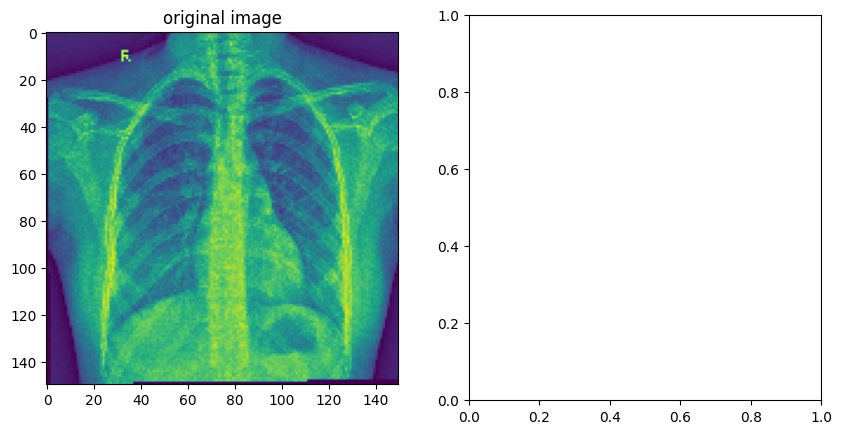

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(train_set[0], cmap='gray')
axs[1].imshow(predicted_train_images[0], cmap='gray')
axs[0].set_title('original image')
axs[1].set_title('predicted image')
for ax in axs:
    ax.axis('off')
plt.show()

#### Heap map of anomalies

In [ ]:

normal_mse = np.mean(np.square(train_set - predicted_train_images), axis=(1, 2))
threshold = np.mean(normal_mse) + 2*np.std(normal_mse)
print("mean+std threshold: ", threshold)
# threshold = np.max(normal_mse)
# print("max threshold: ", threshold)

predicted_test_images = model.predict(test_set)
predicted_test_mse = np.mean(np.square(predicted_test_images - test_set), axis=(1, 2))
predicted_test_labels = ['NORMAL' if mse < threshold else 'PNEUMONIA' for mse in predicted_test_mse]
acc = np.sum(predicted_test_labels == test_labels) / len(test_labels)
print(f"Test accuracy: {acc}")
print('Normal MSE:', np.mean(normal_mse))
print('Test normal MSE:', np.mean(predicted_test_mse[test_labels == 'NORMAL']))
print('Test pneumonia MSE:', np.mean(predicted_test_mse[test_labels == 'PNEUMONIA']))
print('Test MSE difference in accuracy:', abs(np.mean(predicted_test_mse[test_labels == 'NORMAL']) - np.mean(predicted_test_mse[test_labels == 'PNEUMONIA'])))

# create a heat map of misclassified examples
sns.heatmap(confusion_matrix(test_labels, predicted_test_labels), annot=True, cmap="crest", fmt='g', 
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### Histogram of new images

In [ ]:
plt.hist(predicted_test_mse[test_labels == 'PNEUMONIA'], bins=50, color='red', alpha=0.4, label='test pneumonia')
plt.hist(predicted_test_mse[test_labels == 'NORMAL'], bins=50, color='green', alpha=0.4, label='test normal')
# plt.hist(normal_mse, bins=50, color='blue', alpha=0.4, label='train normal')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel("MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()

#### Histogram of new images vs training

In [ ]:
plt.hist(predicted_test_mse[test_labels == 'PNEUMONIA'], bins=50, color='red', alpha=0.4, label='test pneumonia')
plt.hist(predicted_test_mse[test_labels == 'NORMAL'], bins=50, color='green', alpha=0.4, label='test normal')
plt.hist(normal_mse, bins=50, color='blue', alpha=0.4, label='train normal')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel("MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()

In [ ]:
# def show_img(image):
#     plt.imshow(np.array(image), cmap='gray')
#     plt.axis('off')  # Optionally, turn off the axis.
#     plt.show()
    

107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step


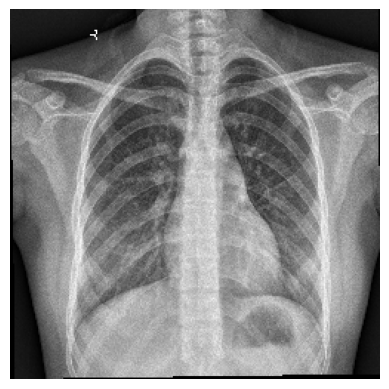

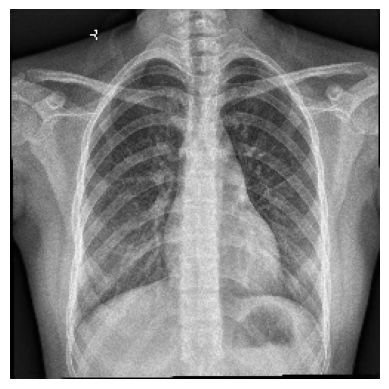

mean+std threshold:  5.956154564046301e-05
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
Test accuracy: 0.8397435897435898
Normal MSE: 1.781153e-05
Test normal MSE: 2.8561628e-05
Test pneumonia MSE: 0.00010529688
Test MSE difference in accuracy: 7.6735254e-05


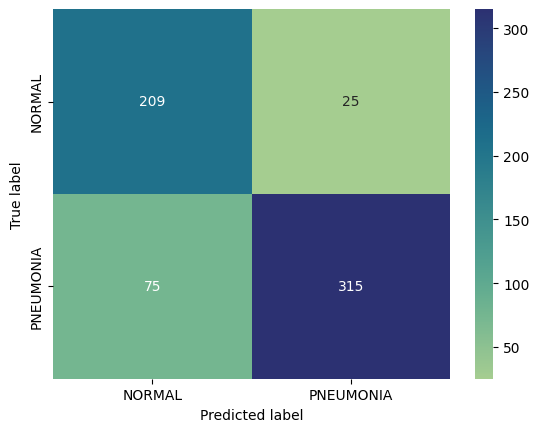

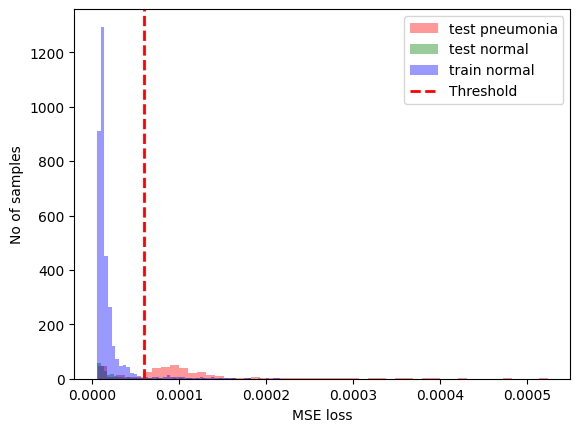

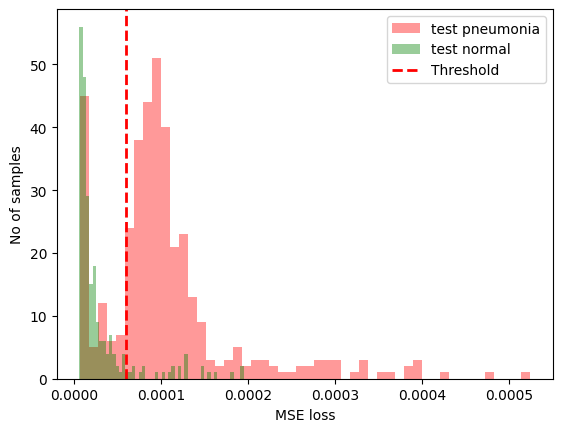

In [ ]:
# autoencoder
# # Reconstruct the input images

# predicted_errors = autoencoder.predict(anomaly_val_images)
# show_img(anomaly_val_images[0])
# show_img(predicted_errors[0])
# # calculate the mean absolute error of each image
# normal_mse = np.mean(np.square(predicted_images - val_images), axis=(1, 2, 3))

# Get reconstruction loss threshold.

normal_mse = np.mean(np.square(train_set - predicted_train_images), axis=(1, 2))
threshold = np.mean(normal_mse) + 2*np.std(normal_mse)
print("mean+std threshold: ", threshold)
# threshold = np.max(normal_mse)
# print("max threshold: ", threshold)

predicted_test_images = model.predict(test_set)
predicted_test_mse = np.mean(np.square(predicted_test_images - test_set), axis=(1, 2))
predicted_test_labels = ['NORMAL' if mse < threshold else 'PNEUMONIA' for mse in predicted_test_mse]
acc = np.sum(predicted_test_labels == test_labels) / len(test_labels)
print(f"Test accuracy: {acc}")
print('Normal MSE:', np.mean(normal_mse))
print('Test normal MSE:', np.mean(predicted_test_mse[test_labels == 'NORMAL']))
print('Test pneumonia MSE:', np.mean(predicted_test_mse[test_labels == 'PNEUMONIA']))
print('Test MSE difference in accuracy:', abs(np.mean(predicted_test_mse[test_labels == 'NORMAL']) - np.mean(predicted_test_mse[test_labels == 'PNEUMONIA'])))

# create a heat map of misclassified examples
sns.heatmap(confusion_matrix(test_labels, predicted_test_labels), annot=True, cmap="crest", fmt='g', 
            xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


# plt.figure(figsize=(8, 8))
# fig.add_subplot(2, 1, 1)
# plt.imshow(np.array(predicted_test_images[0]))
plt.hist(predicted_test_mse[test_labels == 'PNEUMONIA'], bins=50, color='red', alpha=0.4, label='test pneumonia')
plt.hist(predicted_test_mse[test_labels == 'NORMAL'], bins=50, color='green', alpha=0.4, label='test normal')
plt.hist(normal_mse, bins=50, color='blue', alpha=0.4, label='train normal')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel("MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()


plt.hist(predicted_test_mse[test_labels == 'PNEUMONIA'], bins=50, color='red', alpha=0.4, label='test pneumonia')
plt.hist(predicted_test_mse[test_labels == 'NORMAL'], bins=50, color='green', alpha=0.4, label='test normal')
# plt.hist(normal_mse, bins=50, color='blue', alpha=0.4, label='train normal')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel("MSE loss")
plt.ylabel("No of samples")
plt.legend()
plt.show()
